In [1]:
import os
import re
import jieba
import numpy as np
import matplotlib.pyplot as plt
from gensim.models import KeyedVectors
from sklearn.model_selection import train_test_split
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Dense, GRU, Embedding, LSTM, Bidirectional
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard, ReduceLROnPlateau

Using TensorFlow backend.


In [2]:
# 使用gensim加载已经训练好的汉语词向量
cn_model = KeyedVectors.load_word2vec_format('sgns.zhihu.bigram', binary=False)
# 词向量嵌入维度
embedding_dim = cn_model['清华'].shape[0]
print(embedding_dim)
# 词向量模型包含的词语数量255362个，‘清华’为第4574个（索引）
voc=cn_model.vocab['清华']
print(voc)

300
Vocab(count:255362, index:4574)


In [3]:
# 将已经分类好的每条评论的路径放进列表
pos_txts = os.listdir('pos')
neg_txts = os.listdir('neg')
# 好评与差评分别都是2000条
print(len(pos_txts))
print(len(neg_txts))

2000
2000


In [4]:
# 将所有的评论内容放置到一个list里，列表中的每个元素是一条评论
train_texts_orig = [] 
for i in range(len(pos_txts)):
    with open('pos/'+pos_txts[i], 'r', errors='ignore') as f:
        text = f.read().strip()
        train_texts_orig.append(text)
        f.close()
for i in range(len(neg_txts)):
    with open('neg/'+neg_txts[i], 'r', errors='ignore') as f:
        text = f.read().strip()
        train_texts_orig.append(text)
        f.close()

In [5]:
# 元素长度为4000
len(train_texts_orig)

4000

In [6]:
# 对每条评论进行去标点符号处理，然后利用jieba进行中文分词，最后将分出来的每个词转换为词向量中的对应索引，若该词不在词向量中，则索引标记为0，
# 最后将每条评论转换为了词索引的列表
train_tokens = []
for text in train_texts_orig:
    # 去掉标点
    text = re.sub(
        "[\s+\.\!\/_,-|$%^*(+\"\')]+|[+——！，； 。？ 、~@#￥%……&*（）]+", "", text)
    cut = jieba.cut(text)
    cut_list = [i for i in cut]
    for i, word in enumerate(cut_list):
        try:
            # 将词转换为索引index
            cut_list[i] = cn_model.vocab[word].index
        except KeyError:
            # 如果词不在词向量中，则输出0
            cut_list[i] = 0
    train_tokens.append(cut_list)
# print(train_tokens)
print(len(train_tokens))

Building prefix dict from the default dictionary ...
Loading model from cache C:\Users\46124\AppData\Local\Temp\jieba.cache
Loading model cost 0.880 seconds.
Prefix dict has been built succesfully.


4000


In [7]:
# 因为每段评语的长度是不一样的，我们如果单纯取最长的一个评语，并把其他评填充成同样的长度，这样十分浪费计算资源，
# 所以我们取一个折衷的长度，即将索引长度标准化
# 获得每条评论的长度，即分词后词语的个数
num_tokens = [ len(tokens) for tokens in train_tokens ]
# print(num_tokens)
print(len(num_tokens))
# 将列表转换为ndarray格式
num_tokens = np.array(num_tokens)
# print(num_tokens)

4000


In [8]:
# 平均评论的长度
np.mean(num_tokens)

68.77625

In [9]:
# 最长的评价的长度
np.max(num_tokens)

1438

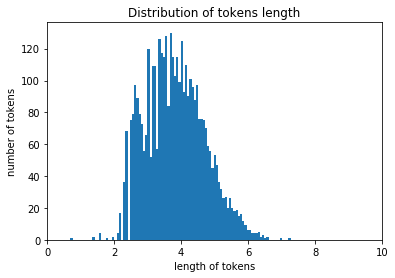

In [10]:
# 绘制评论长度直方图
plt.hist(np.log(num_tokens), bins = 100)
plt.xlim((0,10))
plt.ylabel('number of tokens')
plt.xlabel('length of tokens')
plt.title('Distribution of tokens length')
plt.show()

In [11]:
# 由上面直方图可看出评论长度大致服从正态分布，则评论长度可进行以下取值m，这个值可以涵盖95%左右的样本
mid_tokens = np.mean(num_tokens) + 2 * np.std(num_tokens)
mid_tokens = int(mid_tokens)
mid_tokens

227

In [12]:
# 取评论长度为227后，大约95%的样本被涵盖
np.sum( num_tokens < mid_tokens ) / len(num_tokens)

0.956

In [13]:
# 由于预训练的词向量词汇数为255362，比较大，为了节省训练时间，抽取前50000个词，构建新的词向量
num_words = 50000
# 初始化embedding_matrix，之后在keras上进行应用
embedding_matrix = np.zeros((num_words, embedding_dim))
# embedding_matrix为一个 [num_words，embedding_dim] 的矩阵
# 维度为 50000 * 300
for i in range(num_words):
    embedding_matrix[i,:] = cn_model[cn_model.index2word[i]]
embedding_matrix = embedding_matrix.astype('float32')

In [14]:
# 检查index是否对应，
# 输出300意义为新构建的词向量与预训练的词向量一一对应
print(cn_model[cn_model.index2word[222]])
# print(embedding_matrix[222])
np.sum( cn_model[cn_model.index2word[222]] == embedding_matrix[222] )

[ 1.160710e-01  3.823570e-01  3.350100e-02  6.509880e-01 -4.422000e-03
 -3.975420e-01 -3.907440e-01 -1.683600e-02  6.122400e-02  6.713800e-02
 -6.707850e-01  2.157060e-01 -5.070170e-01  7.741850e-01  4.844490e-01
 -4.285320e-01  1.542340e-01 -6.967980e-01  9.287580e-01  4.554930e-01
 -1.046007e+00  6.835810e-01 -1.509860e-01 -3.230890e-01 -4.166720e-01
  8.421480e-01 -1.314240e-01 -2.506910e-01  6.844910e-01 -1.548800e-01
 -6.630620e-01  6.492340e-01  1.783220e-01 -2.903320e-01  7.403010e-01
  6.675600e-02 -1.797410e-01  1.260600e-02 -7.401170e-01 -7.841450e-01
  2.338000e-02  2.171590e-01  4.285500e-01 -4.258850e-01 -1.838450e-01
 -9.258050e-01 -9.325810e-01  3.774180e-01  9.589400e-02 -1.021126e+00
 -5.428410e-01  3.356190e-01  4.242400e-02  6.216920e-01 -1.315300e-01
 -8.639000e-03 -6.276220e-01  4.994250e-01  7.900700e-02 -4.089200e-02
  6.278660e-01  1.197020e-01  2.085100e-02 -4.527590e-01  4.065140e-01
 -1.684710e-01  3.961030e-01  4.670930e-01 -6.273120e-01 -7.722130e-01
 -3.34

300

In [15]:
# 新建词向量的维度，这个维度为keras的要求，后续会在模型中用到
embedding_matrix.shape

(50000, 300)

In [16]:
# 进行padding（填充）和truncating（裁剪）， 输入的train_tokens是一个list，返回的train_pad是一个numpy array，采用前面（pre）填充的方式
train_pad = pad_sequences(train_tokens, maxlen=mid_tokens,
                            padding='pre', truncating='pre')

In [17]:
# 超出五万个词向量的词用0代替
train_pad[ train_pad>=num_words ] = 0

In [18]:
# 可见padding之后前面的tokens全变成0，文本在最后面
train_pad[33]

array([    0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,

In [19]:
# 准备实际输出结果向量向量，前2000好评的样本设为1，后2000差评样本设为0
train_target = np.concatenate( (np.ones(2000),np.zeros(2000)) )
print(train_target.shape)

(4000,)


In [20]:
# 90%的样本用来训练，剩余10%用来测试
X_train, X_test, y_train, y_test = train_test_split(train_pad,
                                                    train_target,
                                                    test_size=0.1,
                                                    random_state=12)

In [21]:
# 查看训练样本，确认无误，用索引反向生成语句，索引为零的标记为空格字符
def reverse_tokens(tokens):
    text = ''
    for i in tokens:
        if i != 0:
            text = text + cn_model.index2word[i]
        else:
            text = text + ' '
    return text

print(reverse_tokens(X_train[35]))
print('class: ',y_train[35])

                                                                                                                                                                                                               房间很大还有海景阳台走出酒店就是沙滩非常不错唯一遗憾的就是不能刷 不方便
class:  1.0


In [22]:
# 用keras构建顺序模型
model = Sequential()

In [23]:
# 模型第一层为embedding
model.add(Embedding(num_words,
                    embedding_dim,
                    weights=[embedding_matrix],
                    input_length=mid_tokens,
                    trainable=False))

Instructions for updating:
Colocations handled automatically by placer.


In [24]:
# 循环层使用两层LSTM长短期记忆网络，其中第一层为双向的
model.add(Bidirectional(LSTM(units=32, return_sequences=True)))
model.add(LSTM(units=16, return_sequences=False))

In [25]:
# 定义全连接层，激活函数使用sigmoid
model.add(Dense(1, activation='sigmoid'))
# 梯度 下降使用adam算法，学习率设为0.01
optimizer = Adam(lr=1e-3)

In [26]:
# 定义反向传播，使用交叉熵损失函数，评估函数使用平均值
model.compile(loss='binary_crossentropy',
              optimizer=optimizer,
              metrics=['accuracy'])

In [27]:
# 查看模型的结构，一共90k左右可训练的变量
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 227, 300)          15000000  
_________________________________________________________________
bidirectional_1 (Bidirection (None, 227, 64)           85248     
_________________________________________________________________
lstm_2 (LSTM)                (None, 16)                5184      
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 17        
Total params: 15,090,449
Trainable params: 90,449
Non-trainable params: 15,000,000
_________________________________________________________________


In [28]:
# 建立一个权重的存储点，保存训练中的最好模型
path_checkpoint = 'sentiment_checkpoint.keras'
checkpoint = ModelCheckpoint(filepath=path_checkpoint, monitor='val_loss' , verbose=1 , 
save_weights_only=True , save_best_only=True)

In [29]:
# 尝试加载已训练模型
try:
    model.load_weights(path_checkpoint)
except Exception as e:
    print(e)

Unable to open file (unable to open file: name = 'sentiment_checkpoint.keras', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)


In [30]:
# 定义early stoping如果3个epoch内validation loss没有改善则停止训练
earlystopping = EarlyStopping(monitor='val_loss', patience=3, verbose=1)

In [31]:
# 自动降低learning rate
lr_reduction = ReduceLROnPlateau(monitor='val_loss',
                                       factor=0.1, min_lr=1e-5, patience=0,
                                       verbose=1)

In [32]:
# 定义callback函数
callbacks = [
    earlystopping,
#     checkpoint,
    lr_reduction
]

In [33]:
# 开始训练
model.fit(X_train, y_train,
          validation_split=0.1, 
          epochs=20,
          batch_size=128,
          callbacks=callbacks)

Instructions for updating:
Use tf.cast instead.
Train on 3240 samples, validate on 360 samples
Epoch 1/20
3240/3240 [==============================] - 21s 6ms/step - loss: 0.6494 - acc: 0.6225 - val_loss: 0.5470 - val_acc: 0.7444
Epoch 2/20
3240/3240 [==============================] - 18s 6ms/step - loss: 0.4689 - acc: 0.7907 - val_loss: 0.3983 - val_acc: 0.8556
Epoch 3/20
3240/3240 [==============================] - 18s 5ms/step - loss: 0.4016 - acc: 0.8235 - val_loss: 0.3841 - val_acc: 0.8472
Epoch 4/20
3240/3240 [==============================] - 18s 5ms/step - loss: 0.3588 - acc: 0.8534 - val_loss: 0.3667 - val_acc: 0.8639
Epoch 5/20
3240/3240 [==============================] - 18s 5ms/step - loss: 0.3394 - acc: 0.8651 - val_loss: 0.3837 - val_acc: 0.8500

Epoch 00005: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
Epoch 6/20
3240/3240 [==============================] - 18s 5ms/step - loss: 0.3159 - acc: 0.8762 - val_loss: 0.3229 - val_acc: 0.8722
Epoch 7/20
32

In [34]:
result = model.evaluate(X_test, y_test)
print('Accuracy:{0:.2%}'.format(result[1]))

400/400 [==============================] - 1s 3ms/step
Accuracy:87.75%
